## Initial Cleaning Steps

I read this data in as string because it was difficult to do so otherwise

In [40]:
# import data csv
import pandas as pd
df = pd.read_csv("loan.csv", delimiter = ",",index_col=False, dtype = "str")

In [58]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
#check shape to ensure data transferred as expected
df.shape

(2260668, 145)

In [42]:
# remove any columns that have a huge no-value count 
df.dropna(thresh = 1500000, axis = 1, inplace = True)

In [43]:
df.shape

(2260668, 87)

In [14]:
# check dependent variable counts
print(df["loan_status"].value_counts())

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64


In [44]:
# remove unwanted categories from dependent variable
df = df[df.loan_status != "Current"]
df = df[df.loan_status != "Late (31-120 days)"]
df = df[df.loan_status != "Late (16-30 days)"]
df = df[df.loan_status != "In Grace Period"]
df = df[df.loan_status != "Default"]
df = df[df.loan_status != "Does not meet the credit policy. Status:Fully Paid"]
df = df[df.loan_status != "Does not meet the credit policy. Status:Charged Off"]


In [45]:
df.shape

(1303607, 87)

In [46]:
df.isna().sum()

loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
int_rate                           0
installment                        0
grade                              0
sub_grade                          0
emp_title                      82579
emp_length                     75454
home_ownership                     0
annual_inc                         0
verification_status                0
issue_d                            0
loan_status                        0
pymnt_plan                         0
purpose                            0
title                          15426
zip_code                           1
addr_state                         0
dti                              312
delinq_2yrs                        0
earliest_cr_line                   0
inq_last_6mths                     1
open_acc                           0
pub_rec                            0
revol_bal                          0
r

In [36]:
# remove any columns that have a huge no-value count 
df.dropna(thresh = 15, axis = 1, inplace = True)

In [47]:
df.isna().sum().sum()

2529023

In [48]:
# now remove all rows with any no-value cells in them
df = df.dropna(axis = 0, how = 'any')

In [49]:
df.shape

(955257, 87)

In [50]:
#export to csv
df.to_csv('Data_no_NAN.csv')

Exported this to CSV as loading the full data again and again was becoming cumbersome. After this, I only work with the new CSV.

## Secondary Steps

In [51]:
# Read in the cleaned csv
import pandas as pd
final = pd.read_csv('Data_no_NAN.csv')

In [52]:
# check shape
final.shape

(955257, 88)

I removed certain columns from the analysis because this was information a lender would not have while giving a loan and so it was giving the model very high predictive powers.

In [53]:
# Remove columns that represent information not necessary or not information available to lender while giving the loan
final = final.drop(['debt_settlement_flag','out_prncp','last_pymnt_d','last_pymnt_amnt','out_prncp_inv','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','total_rec_prncp','total_rev_hi_lim','total_rec_int'],axis = 1)

In [54]:
# set the data up to do the train-test split to calculate mutual info scores
from sklearn.model_selection import train_test_split


df_y = final['loan_status']
df_x = final.drop(['loan_status'],axis = 1)

X = df_x
y = df_y

In [55]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y)

[]

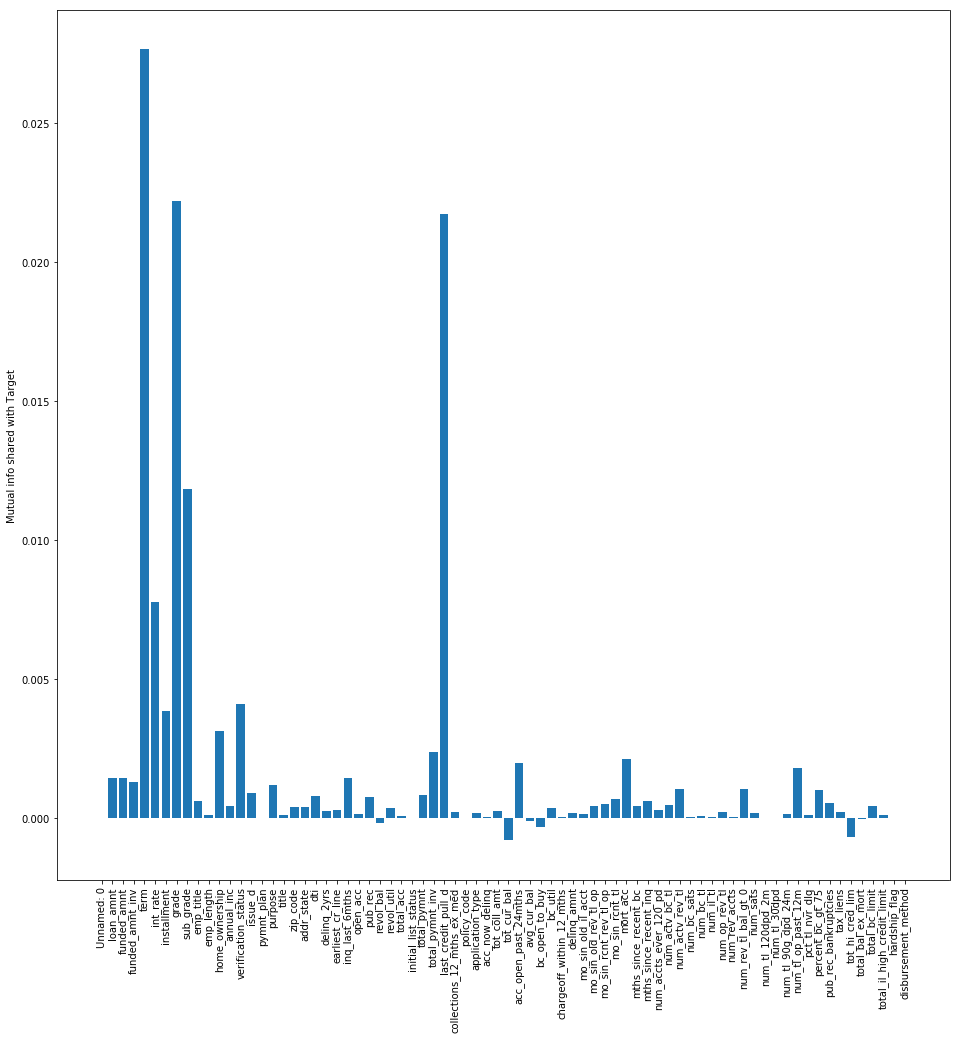

In [57]:
# take a look at the mutual info scores to select which features will be part of the model
from sklearn.metrics import adjusted_mutual_info_score
import matplotlib.pyplot as plt

mutual_info_scores = []

for feature in X_train.columns:
    # Calculate the mutual info score
    m_info = adjusted_mutual_info_score(X_train[feature], y_train)
    # Append it to our list
    mutual_info_scores.append(m_info)

plt.figure(figsize = (16,16))
plt.bar(X_train.columns, mutual_info_scores)
plt.ylabel('Mutual info shared with Target')
plt.xticks(rotation=90)
plt.plot()

In [59]:
# Select the columns with highest mutual information scores
col_list =['loan_status','annual_inc','loan_amnt','term','pub_rec','chargeoff_within_12_mths', 'int_rate', 'installment','grade', 'home_ownership', 'verification_status','purpose','dti','inq_last_6mths','acc_open_past_24mths','mort_acc','num_actv_rev_tl','num_rev_tl_bal_gt_0','num_tl_op_past_12m','percent_bc_gt_75','tot_hi_cred_lim','total_il_high_credit_limit']

In [60]:
# include only the columns selected
final = final[col_list]
final = final[final.purpose != 'educational']

Since assigning positive label to one class was still leading to confusion, I decided to convert the dependent variable to a binary 0 and 1 for the two classes.

In [62]:
import numpy as np
# convert y variable to 0/1 binary
final['status'] = np.where(final['loan_status']=='Charged Off',1,0)

In [ ]:
# check final shape of data
final.shape

In [64]:
# re-do after changes
from sklearn.model_selection import train_test_split


df_y = final['status']
df_x = final.drop(['loan_status','status'],axis = 1)

X = df_x
y = df_y

In [65]:
# do the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y)

In [66]:
# One-hot encode categorical variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)


In [67]:
# Take a look at the data
X_test.head()

,annual_inc,loan_amnt,pub_rec,chargeoff_within_12_mths,int_rate,installment,dti,inq_last_6mths,acc_open_past_24mths,mort_acc,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
576011,65000.0,24000,0,0,18.06,610.23,13.81,0,2,0,...,0,0,0,0,0,0,0,0,0,0
811494,41200.0,12000,1,0,12.49,401.39,28.11,1,6,4,...,0,0,0,0,0,0,0,0,0,0
263650,72000.0,13000,0,0,13.18,296.99,23.80,1,7,4,...,0,0,0,0,0,0,0,0,0,0
815916,50000.0,5500,0,0,6.49,168.55,4.42,2,2,0,...,0,0,0,0,0,0,0,0,0,0
424370,60000.0,30000,0,0,9.17,956.37,15.86,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## Let's now scale data

In [68]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
# Instantiate
scaler.fit(X_train)
# Transform the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

For evaluation purposes, we will not look at just accuracy because data imbalance means the data is already almost 80% of one class. We will try to achieve the highest possible recall so predicting as many of the charged-off class with the highest f1 score.

## Logistic Model

C = 1e-08
Accuracy = 0.619134107819096
Recall = 0.7053140096618358
Precision = 0.3038742152593179
f1 score = 0.4247507767228226
Confusion matrix:
 [[182845 123082]
 [ 22448  53728]]


C = 1e-07
Accuracy = 0.6192021522992491
Recall = 0.705825981936568
Precision = 0.30400538272777644
f1 score = 0.42497174337451293
Confusion matrix:
 [[182832 123095]
 [ 22409  53767]]


C = 1e-06
Accuracy = 0.6202934810770918
Recall = 0.7062591892459568
Precision = 0.30479686818385254
f1 score = 0.42582325169082696
Confusion matrix:
 [[183216 122711]
 [ 22376  53800]]


C = 1e-05
Accuracy = 0.6306519446327299
Recall = 0.6937880697332494
Precision = 0.30969276836621684
f1 score = 0.4282316907656718
Confusion matrix:
 [[188124 117803]
 [ 23326  52850]]


C = 0.0001
Accuracy = 0.6416542136544335
Recall = 0.6774180844360429
Precision = 0.3147388002805648
f1 score = 0.4297904060700201
Confusion matrix:
 [[193575 112352]
 [ 24573  51603]]


C = 0.001
Accuracy = 0.644171859420104
Recall = 0.6738211510186936
Prec

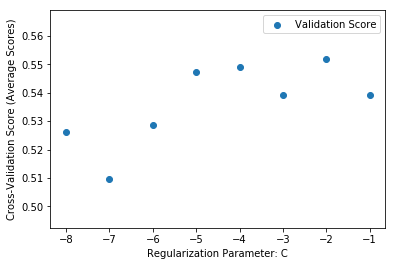

In [70]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Lets plot out different parameters with 5-fold cross validation
accuracy_score_train = []
accuracy_score_test = []
validation_score_list = []
sample_range = [.00000001,.0000001,.000001,.00001,.0001,0.001,0.01,0.1]

for c in sample_range:
    # Instantiate
    LR_model = LogisticRegression(C=c, class_weight = 'balanced')
    validation_score = np.mean(cross_val_score(LR_model, X_train, y_train, cv = 5))
    validation_score_list.append(validation_score)
    
    # Fit
    LR_model.fit(X_train_scaled, y_train)
    
    # predict
    pred_train = LR_model.predict(X_train_scaled)
    pred_test = LR_model.predict(X_test_scaled)

    #Score
    Train_score = LR_model.score(X_train_scaled, y_train)
    Accuracy = LR_model.score(X_test_scaled, y_test)
    recall = recall_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test)
    f1score = f1_score(y_test, pred_test)
    cmat = confusion_matrix(y_test, pred_test)
    
    
    print('C =', c)
    print('Accuracy =', Accuracy)
    print('Recall =', recall)
    print('Precision =', precision)
    print('f1 score =', f1score)
    print('Confusion matrix:\n', cmat)
    print('\n')
    

%matplotlib inline
plt.scatter(np.log10(sample_range), validation_score_list,label="Validation Score",marker='o')
plt.legend()
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross-Validation Score (Average Scores)')
plt.show();

    
    

## Let's try Decision Trees and see if they give better f1 scores

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
    
for i in np.arange(1,50,10):
    # Instantiate
    my_tree = DecisionTreeClassifier(max_depth = i, class_weight = 'balanced')

    # Fit
    my_tree.fit(X_train_scaled, y_train)

    # predict
    pred_train = my_tree.predict(X_train_scaled)
    pred_test = my_tree.predict(X_test_scaled)

    # Score
    Train_score = my_tree.score(X_train_scaled, y_train)
    Accuracy = my_tree.score(X_test_scaled, y_test)
    recall = recall_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test)
    f1score = f1_score(y_test, pred_test)
    cmat = confusion_matrix(y_test, pred_test)
    
    
    print('C =', i)
    print('Accuracy =', Accuracy)
    print('Recall =', recall)
    print('Precision =', precision)
    print('f1 score =', f1score)
    print('Confusion matrix:\n', cmat)
    print('\n')
    




## Let's see if a Random Forest does better

In [ ]:
from sklearn.ensemble import RandomForestClassifier

for i in np.arange(1,60,10):
    my_random_forest = RandomForestClassifier(n_estimators=i, class_weight = 'balanced')
    my_random_forest.fit(X_train_scaled, y_train)

 # Score
    Train_score = my_random_forest.score(X_train_scaled, y_train)
    Accuracy = my_random_forest.score(X_test_scaled, y_test)
    recall = recall_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test)
    f1score = f1_score(y_test, pred_test)
    cmat = confusion_matrix(y_test, pred_test)
    
    
    print('n_estimators =', i)
    print('Accuracy =', Accuracy)
    print('Recall =', recall)
    print('Precision =', precision)
    print('f1 score =', f1score)
    print('Confusion matrix:\n', cmat)
    print('\n')
    



Both random forest and decision trees give lower f1 scores that logistical regressions. I decided to go with a regularization of 0.01 as it gives me the highest f1 scores but also a high accuracy. I used class weights as balanced to account for class imbalance.

In [71]:
# check for value counts of y labels to determine data class imbalance
import numpy as np
np.unique(y_test, return_counts=True)

(array([0, 1]), array([305927,  76176]))

### Final Model

In [75]:
import numpy as np
from sklearn import metrics
# Instantiate using balanced class weights to account for class-imbalance
LR_model = LogisticRegression(C=0.01, class_weight = 'balanced')

# Fit
LR_model.fit(X_train_scaled, y_train)
    
# predict
pred_train = LR_model.predict(X_train_scaled)
pred_test = LR_model.predict(X_test_scaled)

# Score
Train_score = LR_model.score(X_train_scaled, y_train)
Accuracy = LR_model.score(X_test_scaled, y_test)
recall = recall_score(y_test, pred_test)
precision = precision_score(y_test, pred_test)
f1score = f1_score(y_test, pred_test)
cmat = confusion_matrix(y_test, pred_test)

print('C =', c)
print('Accuracy =', Accuracy)
print('Recall =', recall)
print('Precision =', precision)
print('f1 score =', f1score)
print('Confusion matrix:\n', cmat)
print('\n')


    

C = 0.1
Accuracy = 0.644705746879768
Recall = 0.672416509136736
Precision = 0.31613249643577923
f1 score = 0.43007015024999684
Confusion matrix:
 [[195122 110805]
 [ 24954  51222]]




In [87]:
# Calculate Probability for ROC curve
pred_test_proba = LR_model.predict_proba(X_test_scaled)[:,1]


In [88]:
pred_test_proba.shape

(382103,)

In [86]:
pred_test.shape

(382103,)

In [81]:
y_test.shape

(382103,)

### Challenges and improvements

- While I tried SMOTE in some previous iterations (not doumented here) I didn't test random forest and decision trees with class_weights given time constraints. I would like to see the difference in results if the model has a similar function.

- Add more features into the model to see if the f1 score can be boosted overall across different types of models. 

  

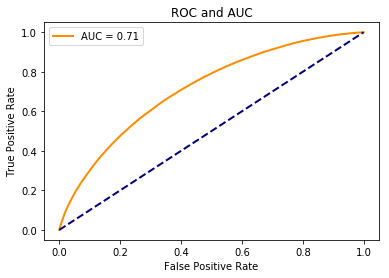

AUC score: 0.714


In [89]:
# model evaluation
from sklearn.metrics import roc_curve, auc    

fpr, tpr, _ = roc_curve(y_test, pred_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="best")
plt.show()
print("AUC score: %3.3f" % roc_auc)

In [90]:
columns = (list(X_train))

In [91]:
a = (LR_model.coef_)


In [92]:
# print out column names as columns and coefficients as values
col3= df = pd.DataFrame(a,columns=columns)
col3.head()

,annual_inc,loan_amnt,pub_rec,chargeoff_within_12_mths,int_rate,installment,dti,inq_last_6mths,acc_open_past_24mths,mort_acc,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,-0.036677,-0.139909,0.030879,0.004337,0.100536,0.233188,0.146025,0.026538,0.124581,-0.106154,...,0.025029,-0.004345,0.011003,0.013278,0.010526,0.009631,-0.001179,0.044031,0.011005,-0.014944


In [ ]:
#export to csv
col3.to_csv('C:/Users/Farhan/Documents/Capstone/coefficients.csv')